In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import CubicSpline

%matplotlib notebook


### Objective

I am trying to compute the (non-smooth) objective of Eq 6,7,8,9 and 10 in the Du, Jin, Lee, Jordan and Singh paper. As a sanity check I plot it in 2D and compare to Eq 3. (which I assume is the same function???). Here is what Eq 3 looks like

![two_d](index.png)

<IPython.core.display.Javascript object>


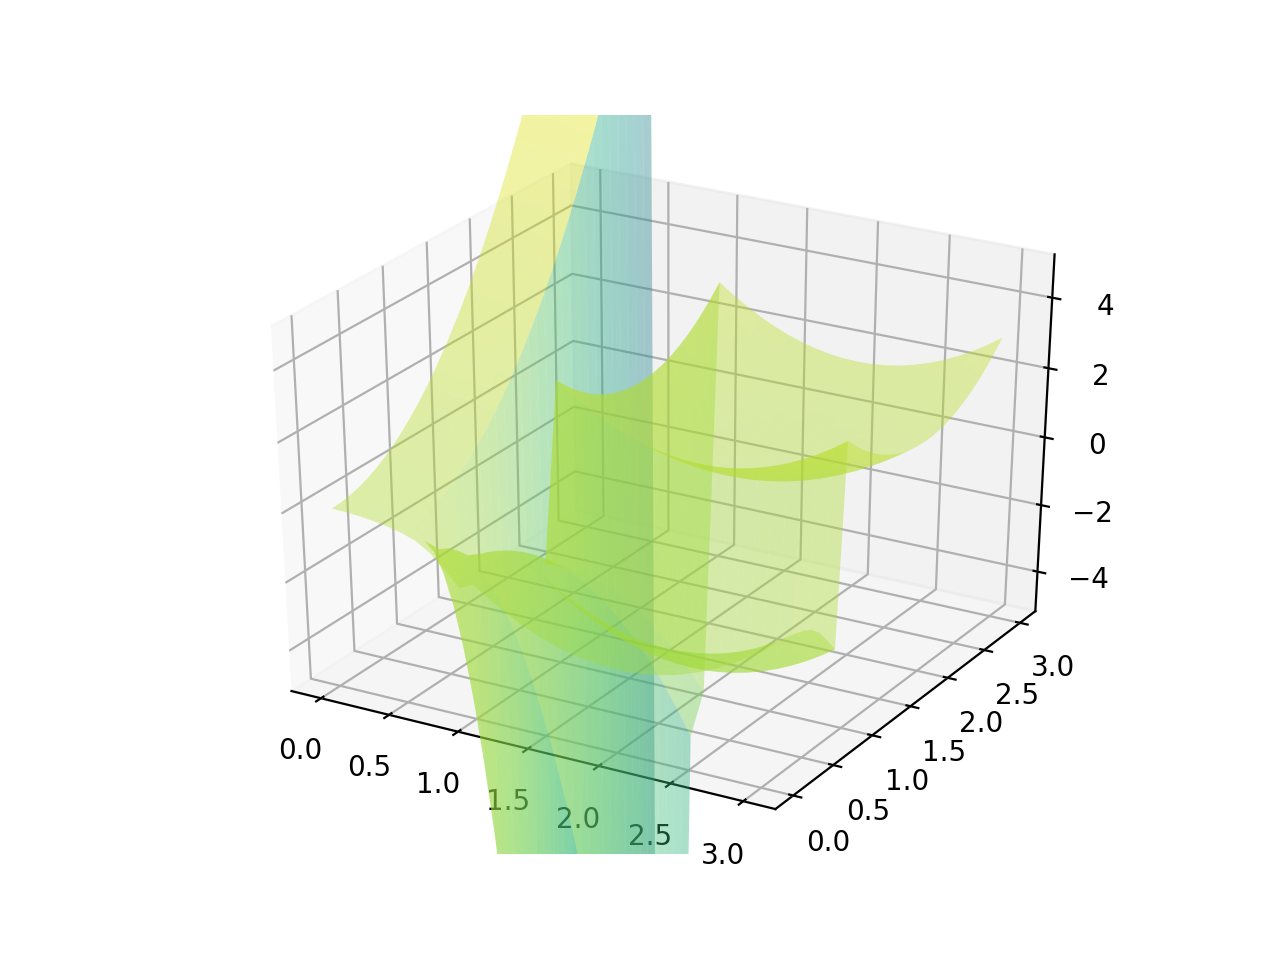

<IPython.core.display.Javascript object>


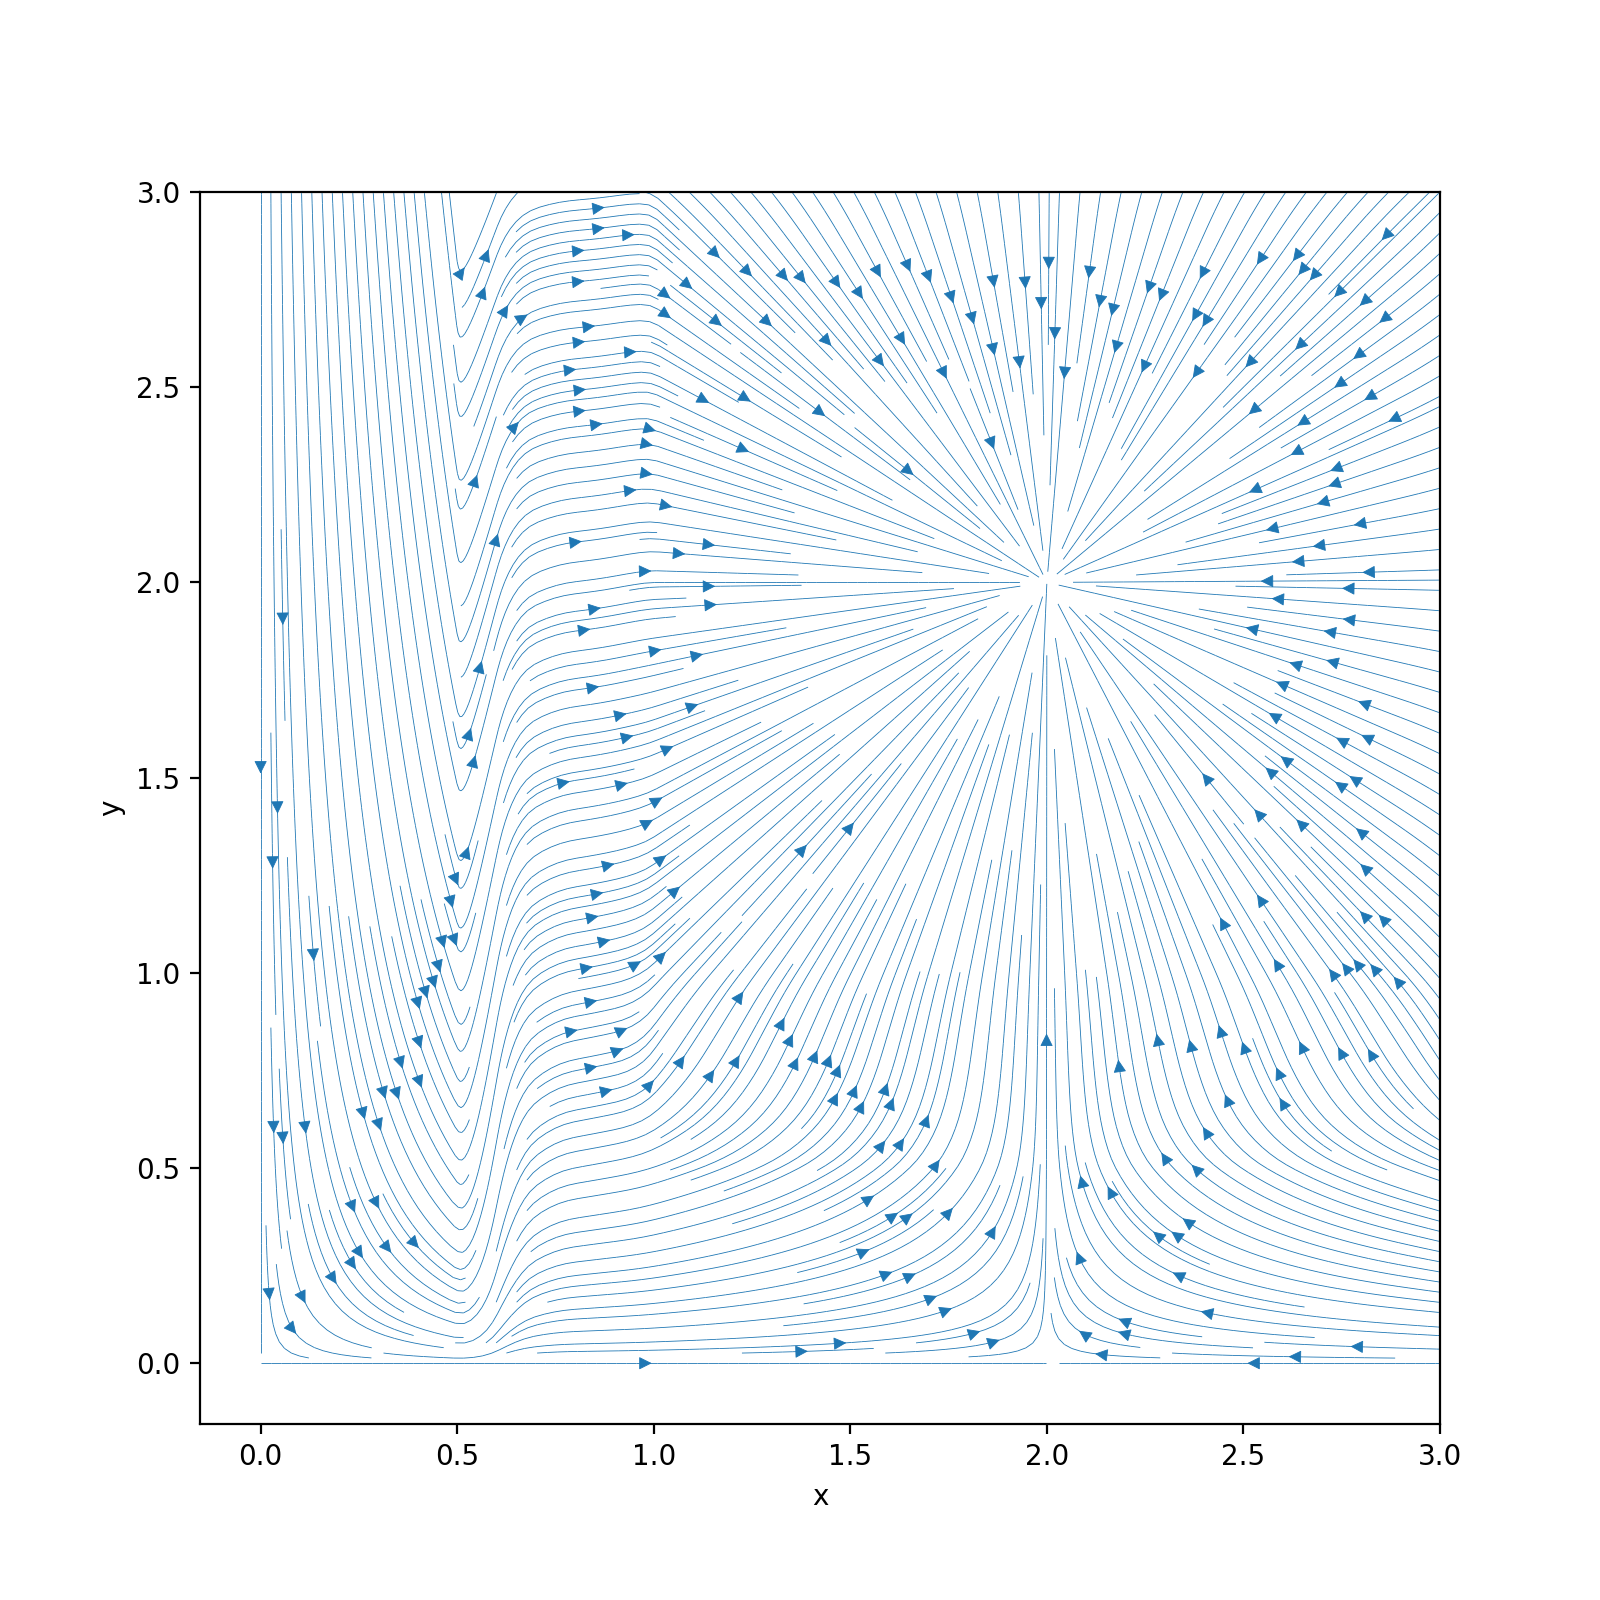

In [58]:
make_plot()

In [55]:
### Function value computations dependent on domain
def f_0_1(w,L,gamma,tau,v,index,d):
    return -gamma*w[0]**2+np.dot(np.ones(d-1),L*w[1:d]**2) 

def f_0_2(w,L,gamma,tau,v,index,d):
    #for the spline we need objective value and derivative at left and right end (tau and 2tau)
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    if d<3:
        return 0+g_func(w,L,gamma,tau,v,index,d,y,y_prime)
    else:
        return np.dot(np.ones(d-index-2),L*w[index+2:d]**2)+g_func(w,L,gamma,tau,v,index,d,y,y_prime)

def f_i_1(w,L,gamma,tau,v,index,d):
    return np.dot(np.ones(index),L*(w[0:index]-4*tau)**2)-gamma*w[index]**2+np.dot(np.ones(d-(index+1)),L*w[index+1:d]**2)-(index-1)*v           

def f_i_2(w,L,gamma,tau,v,index,d):
    #prepare stuff for spline
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    return np.dot(np.ones(index),L*(w[0:index]-4*tau)**2)+g_func(w,L,gamma,tau,v,index,d,y,y_prime)+np.dot(np.ones(d-(index+2)),L*w[index+2:d]**2)-(index-1)*v

def f_d_1(w,L,gamma,tau,v,index,d):
    return np.dot(np.ones(d-1),L*(w[0:d-1]-4*tau)**2)-gamma*w[d-1]**2-(d-1)*v

def f_d_2(w,L,gamma,tau,v,index,d):
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    return np.dot(np.ones(d-1),L*(w[0:d-1]-4*tau)**2)+g_1_func(w,L,gamma,tau,v,index,d,y,y_prime)-(d-1)*v

### Gradient computations dependent on domain

def f_0_1_prime(w,L,gamma,tau,v,index,d):
    return np.concatenate((np.array([-2*gamma*w[index]]),2*L*w[index+1:d]))

def f_0_2_prime(w,L,gamma,tau,v,index,d):
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    if d<3:
        return g_prime(w,L,gamma,tau,v,index,d,y,y_prime)
    else:
        return np.concatenate((g_prime(w,L,gamma,tau,v,index,d,y,y_prime),2*L*w[index+2:d])) #throws error in 2d since index+2>d

def f_i_1_prime(w,L,gamma,tau,v,index,d):
    return np.concatenate((2*L*(w[0:index]-4*tau),np.array([-2*gamma*w[index]]),2*L*w[index+1:d]))

def f_i_2_prime(w,L,gamma,tau,v,index,d):
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    return np.concatenate((2*L*(w[0:index-1]-4*tau),g_prime(w,L,gamma,tau,v,index,d,y,y_prime),2*L*w[index+2:d]))

def f_d_1_prime(w,L,gamma,tau,v,index,d):
    return np.concatenate((2*L*(w[0:d-1]-4*tau),np.array([-gamma*2*w[d-1]])))
    
def f_d_2_prime(w,L,gamma,tau,v,index,d):
    y=np.array([-2*gamma*tau,-4*L*tau])
    y_prime=np.array([-2*gamma,2*L])
    return np.array([2*L*(w[0:d-1]-4*tau),g_1_1_prime(w,L,gamma,tau,v,index,d,y,y_prime)])

### Spline computations

#b) compute connecting functions
def g_func(w,L,gamma,tau,v,index,d,y,y_prime):
    result=g_1_func(w,L,gamma,tau,v,index,d,y,y_prime)+g_2_func(w,L,gamma,tau,v,index,d)*w[index+1]**2
    return result
    
def g_1_func(w,L,gamma,tau,v,index,d,y,y_prime):
    x=np.array([tau,2*tau])
    cs = CubicSpline(x,y,bc_type=((1, y_prime[0]), (1, y_prime[1]))) #CubicSpline(x_values,y_values and derivatives left,right (order,value))
    result=(w[index]-tau)*cs(w[index])-gamma*tau**2
    result=(w[index]-tau)*compute_spline(y,y_prime,w[index],tau)-gamma*tau**2
    return result

def g_2_func(w,L,gamma,tau,v,index,d):
    return -gamma-(10*(L+gamma)*(w[index]-2*tau)**3)/(tau**3)-(15*(L+gamma)*(w[index]-2*tau)**4)/(tau**4)-(6*(L+gamma)*(w[index]-2*tau)**4)/(tau**5)

def g_prime(w,L,gamma,tau,v,index,d,y,y_prime): 
    #first partial derivative
    fpd=g_1_1_prime(w,L,gamma,tau,v,index,d,y,y_prime)+w[index+1]**2*g_2_1_prime(w,L,gamma,tau,v,index,d,y,y_prime)
    #second partial derivative
    spd= 2*w[index+1]*g_2_func(w,L,gamma,tau,v,index,d)
    return np.array([fpd,spd])

def g_1_1_prime(w,L,gamma,tau,v,index,d,y,y_prime):
    x=np.array([tau,2*tau])
    cs = CubicSpline(x,y,bc_type=((1, y_prime[0]), (1, y_prime[1]))) #CubicSpline(x_values,y_values and derivatives left,right (order,value))
    csd=cs.derivative()
    return cs(w[index])+csd(w[index])*w[index]-tau*csd(w[index])

def g_2_1_prime(w,L,gamma,tau,v,index,d,y,y_prime):
    return -(30*(L+gamma)*(w[index]-2*tau)**2*(w[index]-tau)**2)/(tau**5)


def compute_spline(y,y_prime,x,tau):
    c_0=y[0]
    c_1=y_prime[0]
    S=(y[1]-y[0])/(2*tau-tau)
    c_2=(3*S-y_prime[1]-2*y_prime[0])/(2*tau-tau)
    c_3=-(2*S-y_prime[1]-y_prime[0])/(2*tau-tau)**2
    return c_0+c_1*(x-tau)+c_2*(x-tau)**2+c_3*(x-tau)**3

### Compose above objectives   
def compute_loss_final(w):
    d=w.shape[0]
    L=1.5
    gamma=1
    tau=1/2
    v=(17/6*gamma+11/2*L)*tau**2
    # We compute the loss based on where in the domain the current iterate is

    # a) around minimizer, i.e. w_i>2tau in all dimensions:
    if (w>= 2*tau).all()  and  (w<=6*tau).all():
        loss= np.dot(np.ones(d),L*(w-4*tau)**2)
    else:
    # b) find the first element in 0,...,d-1 that is lower than 2 tau
        index=np.argmax(w<2*tau,0)

        if index==0: #1. first dimension
            if w[index]>tau:    
                loss=f_0_2(w,L,gamma,tau,v,index,d)
            else:
                loss=f_0_1(w,L,gamma,tau,v,index,d)
                

        elif index==d-1: #2. last dimension
            if w[index]>tau:
                loss=f_d_2(w,L,gamma,tau,v,index,d)
            else:
                loss= f_d_1(w,L,gamma,tau,v,index,d)

        else: #c)3. all others
            if w[index]>tau:
                loss=f_i_2(w,L,gamma,tau,v,index,d)
            else:
                loss=f_i_1(w,L,gamma,tau,v,index,d)
    return loss


### Compose above gradients   
   
    
def compute_gradients_final(w):
    d=w.shape[0]
    L=1.5
    gamma=1
    tau=1/2
    v=(17/6*gamma+11/2*L)*tau**2

    # We compute the gradients based on where in the domain the current iterate is

    # a) around minimizer, i.e. w_i>2tau in all dimensions:
    if (w>= 2*tau).all()  and  (w<=6*tau).all():
        grad= 2*L*(w-4*tau)

    else:    
    # b) find the first element in 0,...,d-1 that is lower than 2 tau
        index=np.argmax(w<2*tau,0)
        if index==0: #1. first dimension
            if w[index]>tau:
                grad=f_0_2_prime(w,L,gamma,tau,v,index,d)    

            else:
                grad=f_0_1_prime(w,L,gamma,tau,v,index,d)

                
        elif index==d-1: #2. last dimension
            if w[index]>tau:
                grad=f_d_2_prime(w,L,gamma,tau,v,index,d)          
            else:
                grad=f_d_1_prime(w,L,gamma,tau,v,index,d)

        else: #c)3. all others
            if w[index]>tau:
                grad=f_i_2_prime(w,L,gamma,tau,v,index,d)

            else:
                grad=f_i_1_prime(w,L,gamma,tau,v,index,d)

    return grad



In [51]:
### Function value computations dependent on domain
def f_0_1(w,L,gamma,tau,v,index,d):
    return -gamma*w[0]**2+np.dot(np.ones(d-1),L*w[1:d]**2) 

def f_0_2(w,L,gamma,tau,v,index,d):
    #for the spline we need objective value and derivative at left and right end (tau and 2tau)
    (y,y_prime)=prepare_spline_0(w,L,gamma,tau,v,index,d)
    if d<3:
        return 0+g_func(w,L,gamma,tau,v,index,d,y,y_prime)
    else:
        return np.dot(np.ones(d-index-2),L*w[index+2:d]**2)+g_func(w,L,gamma,tau,v,index,d,y,y_prime)

def f_i_1(w,L,gamma,tau,v,index,d):
    return np.dot(np.ones(index),L*(w[0:index]-4*tau)**2)-gamma*w[index]**2+np.dot(np.ones(d-(index+1)),L*w[index+1:d]**2)-(index-1)*v           

def f_i_2(w,L,gamma,tau,v,index,d):
    #prepare stuff for spline
    (y,y_prime)=prepare_spline_i(w,L,gamma,tau,v,index,d)
    return np.dot(np.ones(index),L*(w[0:index]-4*tau)**2)+g_func(w,L,gamma,tau,v,index,d,y,y_prime)+np.dot(np.ones(d-(index+2)),L*w[index+2:d]**2)-(index-1)*v

def f_d_1(w,L,gamma,tau,v,index,d):
    return np.dot(np.ones(d-1),L*(w[0:d-1]-4*tau)**2)-gamma*w[d-1]**2-(d-1)*v

def f_d_2(w,L,gamma,tau,v,index,d):
    (y,y_prime)=prepare_spline_d(w,L,gamma,tau,v,index,d)
    return np.dot(np.ones(d-1),L*(w[0:d-1]-4*tau)**2)+g_1_func(w,L,gamma,tau,v,index,d,y,y_prime)-(d-1)*v

### Gradient computations dependent on domain

def f_0_1_prime(w,L,gamma,tau,v,index,d):
    return np.concatenate((np.array([-2*gamma*w[index]]),2*L*w[index+1:d]))

def f_0_2_prime(w,L,gamma,tau,v,index,d):
    (y,y_prime)=prepare_spline_0(w,L,gamma,tau,v,index,d)
    if d<3:
        return g_prime(w,L,gamma,tau,v,index,d,y,y_prime)
    else:
        return np.concatenate((g_prime(w,L,gamma,tau,v,index,d,y,y_prime),2*L*w[index+2:d])) #throws error in 2d since index+2>d

def f_i_1_prime(w,L,gamma,tau,v,index,d):
    return np.concatenate((2*L*(w[0:index]-4*tau),np.array([-2*gamma*w[index]]),2*L*w[index+1:d]))

def f_i_2_prime(w,L,gamma,tau,v,index,d):
    (y,y_prime)=prepare_spline_i(w,L,gamma,tau,v,index,d)
    return np.concatenate((2*L*(w[0:index-1]-4*tau),g_prime(w,L,gamma,tau,v,index,d,y,y_prime),2*L*w[index+2:d]))

def f_d_1_prime(w,L,gamma,tau,v,index,d):
    return np.concatenate((2*L*(w[0:d-1]-4*tau),np.array([-gamma*2*w[d-1]])))
    
def f_d_2_prime(w,L,gamma,tau,v,index,d):
    (y,y_prime)=prepare_spline_d(w,L,gamma,tau,v,index,d)
    return np.array([2*L*(w[0:d-1]-4*tau),g_1_1_prime(w,L,gamma,tau,v,index,d,y,y_prime)])

### Spline computations
#a) set border values
def prepare_spline_0(w,L,gamma,tau,v,index,d):
     #for the spline we need objective value and derivative at left and right end (tau and 2tau)
    _w = np.empty_like(w)
    _w[:] = w
    __w=np.empty_like(w)
    __w[:]= w
    
    _w[index]=tau
    #__w[index+1]=0
    __w[index]=2*tau

    y=np.array([f_0_1(_w,L,gamma,tau,v,index,d),f_0_1(__w,L,gamma,tau,v,index+1,d)])  #objective values
    y=np.array([f_0_1(np.array([tau]),L,gamma,tau,v,index,d),f_0_1(np.array([2*tau]),L,gamma,tau,v,index+1,d)])  #objective values

    y_prime=np.array([f_0_1_prime(_w,L,gamma,tau,v,index,d)[index],f_0_1_prime(__w,L,gamma,tau,v,index+1,d)[index]]) #partial derivatives
    return (y,y_prime)

def prepare_spline_i(w,L,gamma,tau,v,index,d):
    _w = np.empty_like(w)
    _w[:] = w
    __w=np.empty_like(w)
    __w[:]= w
    
    _w[index]=tau
    __w[index]=2*tau
    #__w[index+1]=0
    y=np.array([f_i_1(_w,L,gamma,tau,v,index,d),f_i_1(__w,L,gamma,tau,v,index+1,d)])#objective values
    y_prime=np.array([f_i_1_prime(_w,L,gamma,tau,v,index,d)[index],f_i_1_prime(__w,L,gamma,tau,v,index+1,d)[index]]) #partial derivatives
    return (y,y_prime)

def prepare_spline_d(w,L,gamma,tau,v,index,d):
    _w = np.empty_like(w)
    _w[:] = w
    __w=np.empty_like(w)
    __w[:]=w

    _w[index]=tau
    __w[index]=2*tau #index plus one does not exist anymore
    y=np.array([f_d_1(_w,L,gamma,tau,v,index,d),np.dot(np.ones(d),L*(__w-4*tau)**2)])#objective values
    y_prime=np.array([f_d_1_prime(_w,L,gamma,tau,v,index,d)[index],2*L*(__w-4*tau)[index]]) #partial derivatives

    return (y,y_prime)

#b) compute connecting functions
def g_func(w,L,gamma,tau,v,index,d,y,y_prime):
    result=g_1_func(w,L,gamma,tau,v,index,d,y,y_prime)+g_2_func(w,L,gamma,tau,v,index,d)*w[index+1]**2
    return result
    
def g_1_func(w,L,gamma,tau,v,index,d,y,y_prime):
    x=np.array([tau,2*tau])
    cs = CubicSpline(x,y,bc_type=((1, y_prime[0]), (1, y_prime[1]))) #CubicSpline(x_values,y_values and derivatives left,right (order,value))
    result=(w[index]-tau)*cs(w[index])-gamma*tau**2
    result=(w[index]-tau)*compute_spline(y,y_prime,w[index],tau)-gamma*tau**2
    return result

def g_2_func(w,L,gamma,tau,v,index,d):
    return -gamma-(10*(L+gamma)*(w[index]-2*tau)**3)/(tau**3)-(15*(L+gamma)*(w[index]-2*tau)**4)/(tau**4)-(6*(L+gamma)*(w[index]-2*tau)**4)/(tau**5)

def g_prime(w,L,gamma,tau,v,index,d,y,y_prime): 
    #first partial derivative
    fpd=g_1_1_prime(w,L,gamma,tau,v,index,d,y,y_prime)+w[index+1]**2*g_2_1_prime(w,L,gamma,tau,v,index,d,y,y_prime)
    #second partial derivative
    spd= 2*w[index+1]*g_2_func(w,L,gamma,tau,v,index,d)
    return np.array([fpd,spd])

def g_1_1_prime(w,L,gamma,tau,v,index,d,y,y_prime):
    x=np.array([tau,2*tau])
    cs = CubicSpline(x,y,bc_type=((1, y_prime[0]), (1, y_prime[1]))) #CubicSpline(x_values,y_values and derivatives left,right (order,value))
    csd=cs.derivative()
    return cs(w[index])+csd(w[index])*w[index]-tau*csd(w[index])

def g_2_1_prime(w,L,gamma,tau,v,index,d,y,y_prime):
    return -(30*(L+gamma)*(w[index]-2*tau)**2*(w[index]-tau)**2)/(tau**5)


def compute_spline(y,y_prime,x,tau):
    c_0=y[0]
    c_1=y_prime[0]
    S=(y[1]-y[0])/(2*tau-tau)
    c_2=(3*S-y_prime[1]-2*y_prime[0])/(2*tau-tau)
    c_3=-(2*S-y_prime[1]-y_prime[0])/(2*tau-tau)**2
    return c_0+c_1*(x-tau)+c_2*(x-tau)**2+c_3*(x-tau)**3

### Compose above objectives   
def compute_loss_final(w):
    d=w.shape[0]
    L=1.5
    gamma=1
    tau=1/2
    v=(17/6*gamma+11/2*L)*tau**2
    # We compute the loss based on where in the domain the current iterate is

    # a) around minimizer, i.e. w_i>2tau in all dimensions:
    if (w>= 2*tau).all()  and  (w<=6*tau).all():
        loss= np.dot(np.ones(d),L*(w-4*tau)**2)
    else:
    # b) find the first element in 0,...,d-1 that is lower than 2 tau
        index=np.argmax(w<2*tau,0)

        if index==0: #1. first dimension
            if w[index]>tau:    
                loss=f_0_2(w,L,gamma,tau,v,index,d)
            else:
                loss=f_0_1(w,L,gamma,tau,v,index,d)
                

        elif index==d-1: #2. last dimension
            if w[index]>tau:
                loss=f_d_2(w,L,gamma,tau,v,index,d)
            else:
                loss= f_d_1(w,L,gamma,tau,v,index,d)

        else: #c)3. all others
            if w[index]>tau:
                loss=f_i_2(w,L,gamma,tau,v,index,d)
            else:
                loss=f_i_1(w,L,gamma,tau,v,index,d)
    return loss


### Compose above gradients   
   
    
def compute_gradients_final(w):
    d=w.shape[0]
    L=1.5
    gamma=1
    tau=1/2
    v=(17/6*gamma+11/2*L)*tau**2

    # We compute the gradients based on where in the domain the current iterate is

    # a) around minimizer, i.e. w_i>2tau in all dimensions:
    if (w>= 2*tau).all()  and  (w<=6*tau).all():
        grad= 2*L*(w-4*tau)

    else:    
    # b) find the first element in 0,...,d-1 that is lower than 2 tau
        index=np.argmax(w<2*tau,0)
        if index==0: #1. first dimension
            if w[index]>tau:
                grad=f_0_2_prime(w,L,gamma,tau,v,index,d)    

            else:
                grad=f_0_1_prime(w,L,gamma,tau,v,index,d)

                
        elif index==d-1: #2. last dimension
            if w[index]>tau:
                grad=f_d_2_prime(w,L,gamma,tau,v,index,d)          
            else:
                grad=f_d_1_prime(w,L,gamma,tau,v,index,d)

        else: #c)3. all others
            if w[index]>tau:
                grad=f_i_2_prime(w,L,gamma,tau,v,index,d)

            else:
                grad=f_i_1_prime(w,L,gamma,tau,v,index,d)

    return grad



In [ ]:
def compute_loss(w):
    d=w.shape[0]
    L=1.5
    gamma=1
    tau=1/2
    # We compute the loss based on where in the domain the current iterate is

    # a) around minimizer, i.e. w_i>2tau in all dimensions:
    if (w>= 2*tau).all()  and  (w<=6*tau).all():
        loss= np.dot(np.ones(d),L*(w-4*tau)**2)
    else:
    
    # b) find the first element in 0,...,d-1 that is lower than 2 tau
        index=np.argmax(w<2*tau,0)

        if index==0: #1. first dimension
            if w[index]>tau:
                if d<3:
                    loss=0
                else:
                    loss=np.dot(np.ones(d-index-1),L*w[index+2:d]**2) #throws error in 2d since index+2>d
            else:
                loss=-gamma*w[0]**2+np.dot(np.ones(d-1),L*w[1:d]**2)
        elif index==d-1: #2. last dimension
            if w[index]>tau:
                loss= np.dot(np.ones(d-1),L*(w[0:d-1]-4*tau)**2)        
            else:
                loss= np.dot(np.ones(d-1),L*(w[0:d-1]-4*tau)**2)-gamma*w[d-1]**2
        else: #c)3. all others
            if w[index]>tau:
                loss=np.dot(np.ones(index),L*(w[0:index]-4*tau)**2)+np.dot(np.ones(d-(index+2),L*w[index+2:d]**2))
            else:
                loss=np.dot(np.ones(index),L*(w[0:index]-4*tau)**2)-gamma*w[index]**2+np.dot(np.ones(d-(index+1),L*w[index+1:d]**2))       
    return loss

def compute_loss2(w):
    d=w.shape[0]
    L=1.5
    gamma=1
    tau=1/2
    # We compute the loss based on where in the domain the current iterate is

    # a) around minimizer, i.e. w_i>2tau in all dimensions:
    if (w>= 2*tau).all()  and  (w<=6*tau).all():
        loss= np.dot(np.ones(d),L*(w-4*tau)**2)
        loss=L*(w[0]-2)**2+L*(w[1]-2)**2


    else:
    
    # b) find the first element in 0,...,d-1 that is lower than 2 tau
        index=np.argmax(w<2*tau,0)

        if index==0: #1. first dimension
            if False:
                if d <3:
                    loss=0
                else:
                    loss=np.dot(np.ones(d-index-1),L*w[index+2:d]**2) #throws error in 2d since index+2>d
            else:
                loss=-gamma*w[0]**2+np.dot(np.ones(d-1),L*w[1:d]**2) #correct

        elif index==d-1: #2. last dimension
            if False:
                loss= np.dot(np.ones(d-1),L*(w[0:d-1]-4*tau)**2)        
            else:
                loss= np.dot(np.ones(d-1),L*(w[0:d-1]-4*tau)**2)-gamma*w[d-1]**2 #correct

        else: #c)3. all others
            if w[index]>tau:
                loss=np.dot(np.ones(index),L*(w[0:index]-4*tau)**2)+np.dot(np.ones(d-(index+2),L*w[index+2:d]**2))

            else:
                loss=np.dot(np.ones(index),L*(w[0:index]-4*tau)**2)-gamma*w[index]**2+np.dot(np.ones(d-(index+1),L*w[index+1:d]**2))       
                
    return loss

def compute_gradients(w):
    d=w.shape[0]
    L=1.5
    gamma=1
    tau=1/2
    # We compute the gradients based on where in the domain the current iterate is

    # a) around minimizer, i.e. w_i>2tau in all dimensions:
    if (w>= 2*tau).all()  and  (w<=6*tau).all():
        grad= 2*L*(w-4*tau)
    else:    
    
    # b) find the first element in 0,...,d-1 that is lower than 2 tau
        index=np.argmax(w<2*tau,0)

        if index==0: #1. first dimension
            if w[index]>tau:
                grad=np.zeros(d)
            else:
                grad=np.array([-2*gamma*w[index], 2*L*w[index+1:d]])

        elif index==d-1: #2. last dimension
            if w[index]>tau:
                grad=np.array([2*L*(w[0:d-1]-4*tau),0])
            else:
                grad=np.array([2*L*(w[0:d-1]-4*tau),-gamma*2*w[d-1]])
        else: #c)3. all others
            if w[index]>tau:
                grad=np.array([0,2*L*(w[0:index-1]-4*tau),2*L*w[index+2:d]])
            else:
                grad=np.array([-2*gamma*w[index],2*L*(w[0:index-1]-4*tau), 2*L*w[index+1:d]])
    return grad

def compute_gradients2(w):
    d=w.shape[0]
    L=1.5
    gamma=1
    tau=1/2
    # We compute the gradients based on where in the domain the current iterate is

    # a) around minimizer, i.e. w_i>2tau in all dimensions:
    if (w>= 2*tau).all()  and  (w<=6*tau).all():
        grad= 2*L*(w-4*tau)
    else:    
    
    # b) find the first element in 0,...,d-1 that is lower than 2 tau
        index=np.argmax(w<2*tau,0)

        if index==0: #1. first dimension
            if False:
                grad=np.zeros(d)
            else:
                grad=np.array([-2*gamma*w[index], 2*L*w[index+1:d]])
                #grad = np.array([-2*gamma*w[0], 2*L* w[1]])   

        elif index==d-1: #2. last dimension
            if False:
                grad=np.array([2*L*(w[0:d-1]-4*tau),0])
            else:
                grad=np.array([2*L*(w[0:d-1]-4*tau),-gamma*2*w[d-1]])

        else: #c)3. all others
            if w[index]>tau:
                grad=np.array([0,2*L*(w[0:index-1]-4*tau),2*L*w[index+2:d]])
            else:
                grad=np.array([-2*gamma*w[index],2*L*(w[0:index-1]-4*tau), 2*L*w[index+1:d]])
    return grad

In [57]:
def make_plot():      

    s=0.1
    x_ax = np.arange(0,3+s, s)  
    y_ax = np.arange(0,3+s, s)  
    x_ax,y_ax = np.meshgrid(x_ax,y_ax)
    loss=np.zeros((x_ax.shape[0],x_ax.shape[1]))
    gradient_x=np.zeros((x_ax.shape[0],x_ax.shape[1]))
    gradient_y=np.zeros((y_ax.shape[0],y_ax.shape[1]))

    for i in range(x_ax.shape[0]):
        for j in range(x_ax.shape[1]):
            loss[i,j]=compute_loss_final(np.array((x_ax[i,j],y_ax[i,j])))
            grad=compute_gradients_final(np.array((x_ax[i,j],y_ax[i,j])))
            gradient_x[i,j]=grad[0]
            gradient_y[i,j]=grad[1]

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax = fig.gca(projection='3d')
    ax.plot_surface(x_ax, y_ax, loss,cmap='viridis', 
                alpha=0.4,zorder=1)
    ax.set_zlim(-5,5)
    

    #1. Plot Gradient Flow
    plt.figure(2)

    #plt.plot()
        
    plt.streamplot(x_ax,y_ax,-gradient_x,-gradient_y, density=4, linewidth='0.3')
    plt.gcf().set_size_inches((8,8))
    plt.show()
    plt.xlabel('x')
    plt.ylabel('y')